In [ ]:
import pathlib
import numpy as np
!pip install scikit-plot
import seaborn as sns
from matplotlib import pyplot
import scikitplot
from sklearn.metrics import classification_report
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import os
import time
import tensorflow_hub as hub
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gauravsharma99/fer13-cleaned-dataset
%mkdir -p dataset/
!unzip -q fer13-cleaned-dataset.zip -d dataset/
INPUT_PATH = "/content/dataset/"

fer13-cleaned-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 594, in _terminate_pool
    worker_handler.join()
  File "/usr/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt
replace dataset/Angry/Training_10017485.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def print_image_distro():
  total_images=0
  for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
  return total_images
total_images = print_image_distro()
print(f"\ntotal images are {total_images}")

disgust has 380 number of images
Angry has 5664 number of images
Happy has 13668 number of images
Neutral has 8590 number of images
fear has 2535 number of images

total images are 30837


In [ ]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

30457

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 225)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 225)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
label_to_text = {}
i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            hr_image = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            hr_image = tf.convert_to_tensor(hr_image, dtype=tf.float32)
            hr_image = tf.expand_dims(hr_image, axis=0)
            hr_image = model(hr_image)
            hr_image = tf.squeeze(hr_image)
            os.remove(str(INPUT_PATH + dir_ + "/" + f))
            save_image(hr_image,str(INPUT_PATH+dir_+"/NEW"+f))
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

loaded all Angry images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all fear images to numpy arrays


In [ ]:
label_to_text

{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'fear'}

In [ ]:
def make_highres_imgs(total_images,emotion,e):
    img_arr = np.empty(shape=(total_images,100,100,3))
    img_label = np.empty(shape=(total_images))
    i = 0
    for f in os.listdir(INPUT_PATH + emotion + '/'):
        hr_image = cv2.imread(INPUT_PATH + emotion + "/" + f)
        img_arr[i] = cv2.resize(hr_image, (100, 100),interpolation=cv2.INTER_AREA)
        img_label[i] = e
        i += 1
    return img_arr, img_label

fear has 2535 number of images

Angry has 2832 number of images

Neutral has 4295 number of images

disgust has 380 number of images

Happy has 6834 number of images

In [ ]:
#label_to_text = {0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'fear'}

In [ ]:
fear_arr , fear_label = make_highres_imgs(2535,label_to_text[3],3)

In [ ]:
angry_arr , angry_label = make_highres_imgs(2832,label_to_text[0],0)

In [ ]:
neutral_arr , neutral_label = make_highres_imgs(4295,label_to_text[2],2)

In [ ]:
happy_arr , happy_label = make_highres_imgs(6834,label_to_text[1],1)

In [ ]:
img_arr = np.concatenate((fear_arr,angry_arr,neutral_arr,happy_arr),axis=0)
img_label = np.concatenate((fear_label,angry_label,neutral_label,happy_label),axis=0)

In [ ]:
img_arr.shape

(16496, 100, 100, 3)

In [ ]:
img_label.shape

(16496,)

In [ ]:
np.save('img_arr',img_arr)

In [ ]:
np.save('img_label',img_label)

In [ ]:
img_arr = np.load('/content/img_arr.npy')
img_label = np.load('/content/img_label.npy')

In [ ]:
print(label_to_text)

{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'fear'}


In [ ]:
print(img_arr.shape, img_label.shape)

(16496, 100, 100, 3) (16496,)


In [ ]:
img_arr = img_arr/255

In [ ]:
unique_elements, counts_elements = np.unique(img_label, return_counts=True)

<BarContainer object of 4 artists>

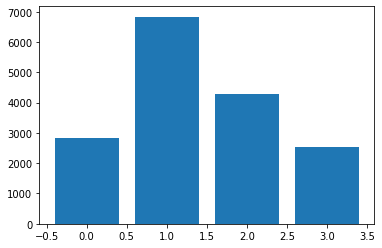

In [ ]:
plt.bar(unique_elements,counts_elements)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 100, 100, 3), (1650, 100, 100, 3), (14846,), (1650,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    shuffle=True, stratify=y_train,
                                                    train_size=0.85, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12619, 100, 100, 3), (2227, 100, 100, 3), (12619,), (2227,))

In [ ]:
def set_distro(x,y):
  unique_elements, counts_elements = np.unique(y, return_counts=True)
  plt.bar(unique_elements,counts_elements)

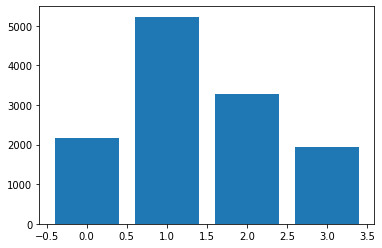

In [ ]:
set_distro(X_train, y_train)

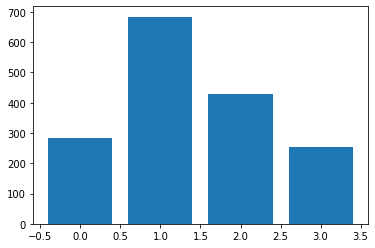

In [ ]:
set_distro(X_test, y_test)

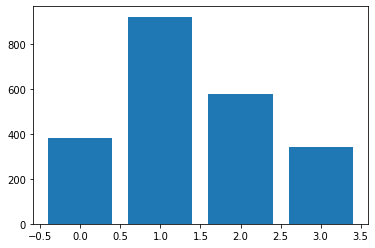

In [ ]:
set_distro(X_val, y_val)

In [ ]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
num_classes

4

In [ ]:
xception = keras.applications.Xception(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
x = xception.output
global_pool = keras.layers.GlobalMaxPool2D(name="global_pool")(x)
out = keras.layers.Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = keras.models.Model(inputs=resnet.input, outputs=out)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [ ]:
filepath="/content/resnet-{epoch:02d}-{val_accuracy:.2f}.hdf5"

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
batch_size = 16
epochs = 50
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    use_multiprocessing=True,
    callbacks = [model_checkpoint_callback]
)

Epoch 1/50
788/788 [==============================] - 209s 242ms/step - loss: 1.1244 - accuracy: 0.5033 - val_loss: 1.0186 - val_accuracy: 0.6197
Epoch 2/50
788/788 [==============================] - 185s 235ms/step - loss: 0.8909 - accuracy: 0.6328 - val_loss: 0.8601 - val_accuracy: 0.6430
Epoch 3/50
788/788 [==============================] - 186s 235ms/step - loss: 0.8129 - accuracy: 0.6705 - val_loss: 0.7623 - val_accuracy: 0.6996
Epoch 4/50
788/788 [==============================] - 185s 234ms/step - loss: 0.7415 - accuracy: 0.7055 - val_loss: 0.7893 - val_accuracy: 0.6991
Epoch 5/50
788/788 [==============================] - 186s 235ms/step - loss: 0.7077 - accuracy: 0.7241 - val_loss: 0.7289 - val_accuracy: 0.7243
Epoch 6/50
788/788 [==============================] - 185s 234ms/step - loss: 0.6905 - accuracy: 0.7282 - val_loss: 0.7237 - val_accuracy: 0.7086
Epoch 7/50
788/788 [==============================] - 184s 234ms/step - loss: 0.6610 - accuracy: 0.7437 - val_loss: 0.7895 -

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

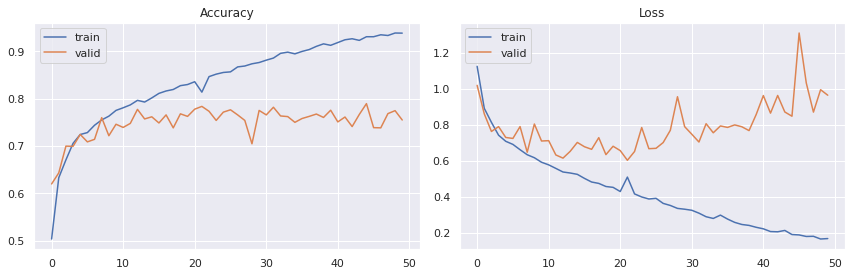

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [ ]:
model.load_weights('/content/xception-28-0.79.hdf5')  

test accuracy: 75.7576 %


              precision    recall  f1-score   support

           0       0.75      0.52      0.62       283
           1       0.91      0.88      0.90       684
           2       0.67      0.77      0.72       430
           3       0.57      0.66      0.61       253

    accuracy                           0.76      1650
   macro avg       0.72      0.71      0.71      1650
weighted avg       0.77      0.76      0.76      1650



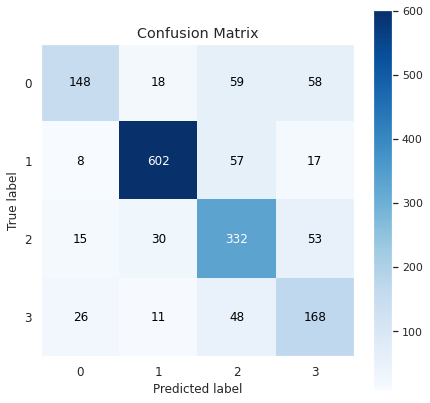

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))


In [ ]:
from keras.preprocessing import image
img = image.load_img('/content/dataset/Happy/Training_10000426.jpg',target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (100, 100, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/dataset/Happy/Training_10000426.jpg')

result=model.predict(image)
result = list(result[0])
print(result)

In [ ]:
img_index = result.index(max(result))
print(label_to_text[img_index])
plt.show()

In [ ]:
model.save('/content/')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/')

In [ ]:
loaded_model.summary()